# Loading Data

In [1]:
1

Intitializing Scala interpreter ...

Spark Web UI available at http://192.168.2.10:4040
SparkContext available as 'sc' (version = 3.0.0, master = local[*], app id = local-1612055748887)
SparkSession available as 'spark'


res0: Int = 1


In [2]:
val housing = spark.read.format("csv").option("header","true").option("inferSchema","true").load("housing.csv")
housing.createOrReplaceTempView("housing")
housing.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

housing: org.apache.spark.sql.DataFrame = [longitude: double, latitude: double ... 8 more fields]


In [3]:
%%python
import databricks.koalas as ks
import tempfile
from matplotlib import pyplot as plt
from IPython.display import Image
ks.set_option("plotting.max_rows", 1000000)

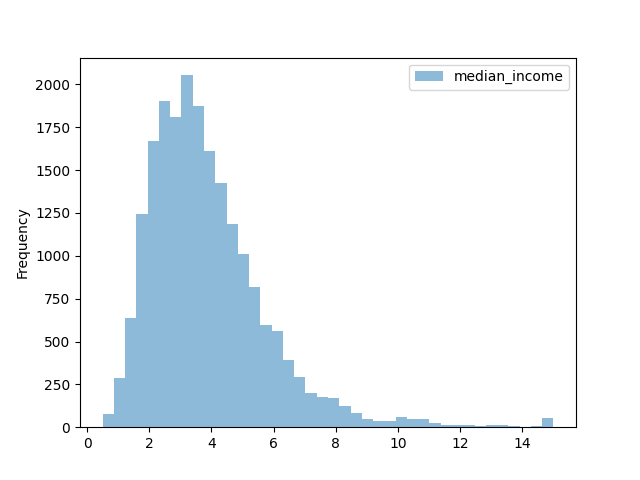

In [4]:
%%python
housing = spark.table("housing").to_koalas()
housing[['median_income']].plot.hist(bins=40, alpha=0.5)
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

# Random Sampling

In [5]:
val Array(train1, test1) = housing
    .randomSplit(Array(0.8, 0.2))
train1.createOrReplaceTempView("train1")
test1.createOrReplaceTempView("test1")

train1: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [longitude: double, latitude: double ... 8 more fields]
test1: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [longitude: double, latitude: double ... 8 more fields]


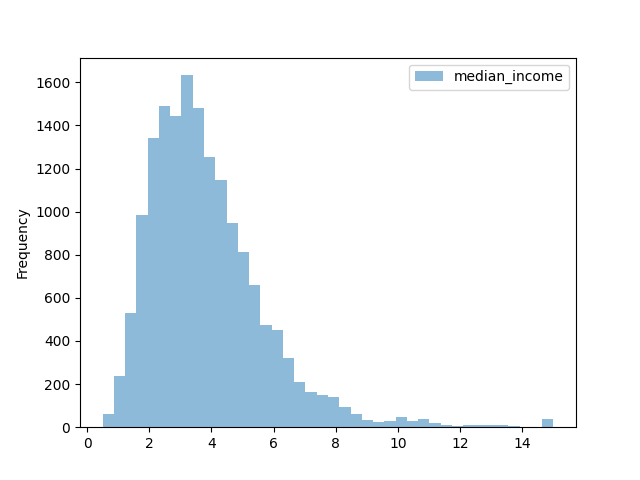

In [6]:
%%python

train1 = spark.table("train1").to_koalas()
train1[['median_income']].plot.hist(bins=40, alpha=0.5)
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

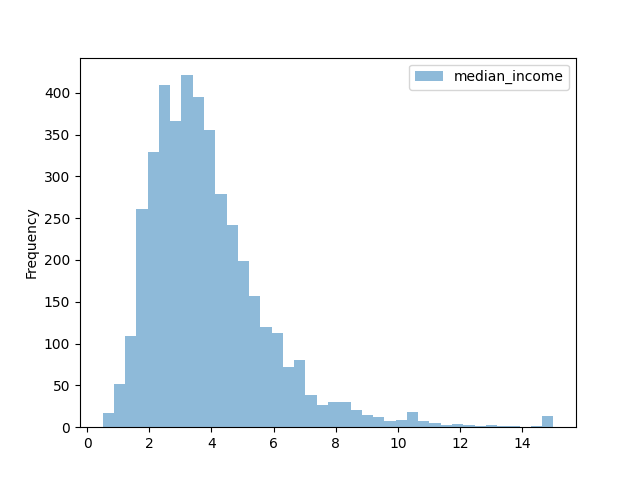

In [7]:
%%python
test1 = spark.table("test1").to_koalas()
test1[['median_income']].plot.hist(bins=40, alpha=0.5)
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

# Stratified Sampling

In [8]:
import org.apache.spark.ml.feature.Bucketizer

val bucketizer = new Bucketizer()
  .setInputCol("median_income")
  .setOutputCol("income_cat")
  .setSplits(Array(0,1.5,3.0,4.5,6,Double.PositiveInfinity))

val housing_temp = bucketizer.transform(housing)
housing_temp.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|income_cat|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|       4.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|       4.0|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|       4.0|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|    

import org.apache.spark.ml.feature.Bucketizer
bucketizer: org.apache.spark.ml.feature.Bucketizer = Bucketizer: uid=bucketizer_30249641aed2
housing_temp: org.apache.spark.sql.DataFrame = [longitude: double, latitude: double ... 9 more fields]


In [9]:
housing_temp.groupBy("income_cat").count.show

+----------+-----+
|income_cat|count|
+----------+-----+
|       0.0|  815|
|       1.0| 6550|
|       4.0| 2373|
|       3.0| 3652|
|       2.0| 7250|
+----------+-----+



In [10]:
val test2 = housing_temp.stat.sampleBy("income_cat", Map(0 -> 0.2, 1->0.2, 2->0.2, 3->0.2, 4->0.2, 5->0.2), 47)
val train2 = housing_temp.except(test2)

test2.createOrReplaceTempView("test2")
train2.createOrReplaceTempView("train2")

test2.groupBy("income_cat").count.show
train2.groupBy("income_cat").count.show

+----------+-----+
|income_cat|count|
+----------+-----+
|       0.0|  150|
|       1.0| 1310|
|       4.0|  474|
|       3.0|  775|
|       2.0| 1514|
+----------+-----+

+----------+-----+
|income_cat|count|
+----------+-----+
|       0.0|  665|
|       1.0| 5240|
|       4.0| 1899|
|       3.0| 2877|
|       2.0| 5736|
+----------+-----+



test2: org.apache.spark.sql.DataFrame = [longitude: double, latitude: double ... 9 more fields]
train2: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [longitude: double, latitude: double ... 9 more fields]


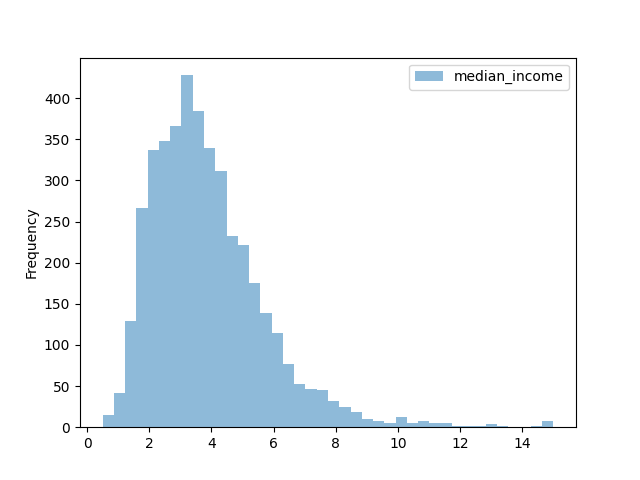

In [11]:
%%python
test2 = spark.table("test2").to_koalas()
test2[['median_income']].plot.hist(bins=40, alpha=0.5)
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

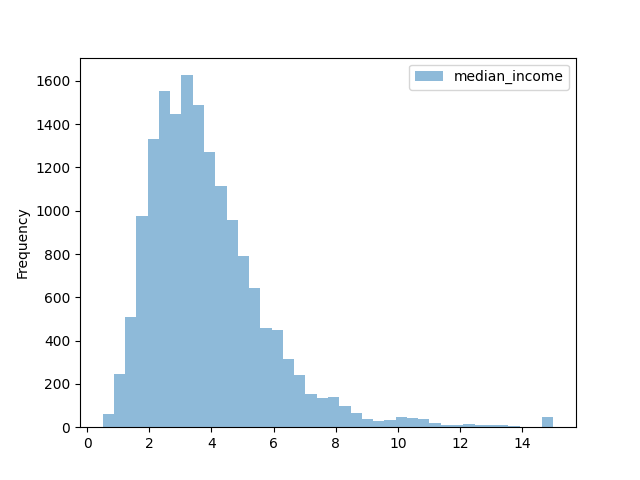

In [12]:
%%python
train2 = spark.table("train2").to_koalas()
train2[['median_income']].plot.hist(bins=40, alpha=0.5)
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)